In [17]:
import numpy as np
import warnings
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=FutureWarning)

[Libreria di riferimento](http://weinbe58.github.io/QuSpin/generated/quspin.basis.spin_basis_1d.html)

We want to write a chain of L coupled qubits:
$$H[h_x(t)] = - \sum_{j=1}^L(JS^z_{j+1}S^z_j+gS^z_j+h_x(t)S^x_j)$$
as in the article we set g=1. 

In the particoular case of single qubit we remove the first term J=0: 

$$H[h_x(t)] = - S^z_j - h_x(t)S^x_j$$

In [12]:
def hamiltonian_eigenprob(L=1,J=1.0,g=1.0,hz=1.0, hx_min=-4., hx_max =4.,Δh=1,n_step=20): 
    if L < 2:
        J=0
    else:
        J=J
#     if L>1: 
    # Nel caso di una chain si fa riferimento a symmetries rappresentate da parametri block, capisci meglio.
    basis = spin_basis_1d(L=L,pauli=0,kblock=0,pblock=1) 
    # Voglio usare il il metodo hamiltoniana, come primo argomento gli serve 
    
    x_field=[[g,i] for i in range(L)]
    z_field=[[hz,i] for i in range(L)]
#     hx_discrete = np.arange(start=hx_min, stop=hx_max, step=Δh)
    # la parte dinamica dell' hamiltoniana nella funzione richiede una lista con
    # [["asse",coefficiente,funzione dipendente da t,parametri funzione dipendente da t]]
    J_nn=[[J,i,(i+1)%L] for i in range(L)] # Periodic Boundary Condition
    static=[["zz",J_nn],["z",z_field]]
    
    h_values =np.arange(hx_min,hx_max,Δh) # discrete set of possible h fields 
    
    def operator(time):
        return h_values[hx_discrete[int(time)]]
    
    hx_discrete = np.zeros(n_step, dtype=int) # hx_discrete are protocols specified as integers
    
    
#     fct = lambda time: h_set[hx_discrete[int(time)]]
    # If the operator is time-INdependent, one must pass an empty list: dynamic_list = [].
    dynamic=[["x",x_field,operator,[]]]
    H=hamiltonian(static,dynamic,static_fmt="dia",dtype=np.float64,basis=basis)
    print("\n\n-------------------------------> Hamiltonian <-------------------------------")
    print("")
    print(H.toarray())
    print("")
    print("------------------------------------------------------------------------------")

    eigensystem = H.eigh()
    print("\n\n---------------------> Eigenvalues, Eigenvectors (in columns)<-------------------------------")
    print("")
    print(eigensystem)
    print("")
    print("------------------------------------------------------------------------------")
    eigenvectors = eigensystem[1]
    eigenvalues = eigensystem[0]
    return H ,eigenvectors,eigenvalues
hamiltonian0(L=3)

Hermiticity check passed!
Symmetry checks passed!


-------------------------------> Hamiltonian <-------------------------------

[[ 2.25       -3.46410162  0.          0.        ]
 [-3.46410162  0.25       -4.          0.        ]
 [ 0.         -4.         -0.75       -3.46410162]
 [ 0.          0.         -3.46410162 -0.75      ]]

------------------------------------------------------------------------------


---------------------> Eigenvalues, Eigenvectors (in columns)<-------------------------------

(array([-6.16876758, -1.61785763,  2.52563332,  6.26099189]), array([[ 0.22432566, -0.48462587,  0.64105626,  0.55123736],
       [ 0.54517616, -0.54111111, -0.05100788, -0.63826321],
       [ 0.68056804,  0.16701869, -0.5261522 ,  0.48176318],
       [ 0.43507252,  0.6666643 ,  0.55642513, -0.23803716]]))

------------------------------------------------------------------------------


<quspin.operators.hamiltonian:
static mat: <4x4 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements (1 diagonals) in DIAgonal format>
dynamic:
 0) func: operator, mat: <4x4 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format> >

**STOCHASTIC DESCENT**
1. Start from a random protocol and proposes local field updates at time t choosing uniformly in the interval [0,T].
2. Magnetic field is changed only if increase the fidelity.
3. Number of fidelity evaluation at most $$20 \times T/\delta t$$
4. Repeat with different initial random protocols.

The set of protocols {$h^{\alpha}|\alpha= 1, \dots, N_{real}$} used to calculate the glass-like order parameter.

In [13]:
def modulus_squared_inner_product(psi1,psi2):
    modulus=np.abs(np.dot(np.conj(psi1.T),psi2))
    return modulus**2
def fidelity(psi_target,psi_rec):
    return modulus_squared_inner_product(psi_target, psi_rec)
def infidelity(psi_target,psi_rec):
    return 1-modulus_squared_inner_product(psi_target, psi_rec)
def update_state(eigenvectors,eigenvalues,psi_in,T):
    c_i = np.array([np.dot(eigenvectors[:,i],psi_in) for i in range(len(psi_in))]) 
    psi_rec = c_i*np.exp(-1j*eigenvalues*T/hbar)*eigenvectors
    return psi_rec

In [6]:
Δt = 0.01
ITERATIONS = 100
NSTEPS = 250
TMAX=4
LIMIT_FED_EVAL=20*TMAX/Δt # set by paper authors
from scipy.constants import hbar

**SPECTRAL METHOD**

First method to evolve the system:

$$|\psi(T)> = \sum_{i=0}^{N_{bit}-1} c_i exp[-i E_i T / \hbar] |E_i>$$

In [14]:
from random import choices
from random import uniform
from tqdm import tnrange

np.random.seed(212)

hx = [-4,4]
_,vec__H_minus4, val_H_minus4 = hamiltonian_eigenprob(L=1g=1.0,hz=1.0, hx=)
_,vec__H_plus4, val_H_plus4 = hamiltonian_eigenprob(L=1g=1.0,hz=1.0, hx=)
fidelity_vec = 

random_protocol = choices(hx, k=NSTEPS) # Define a random protocol, sampling without replacement from a list. 
angle_phase_iniz = uniform(0,2*np.pi)
angle_phase_target = uniform(0,2*np.pi) 
psi_iniz = 1/np.sqrt(2)*np.array([1,1*np.exp(1j*angle_phase_iniz)]) # Start from a random state 2D
psi_targhet = 1/np.sqrt(2)*np.array([1,1*np.exp(1j*angle_phase_target)])# Remember to change first component when things will work.

infidelity_values = []

for j in tnrange(ITERATIONS):
    index_update = np.random.randint(0, NSTEPS-1) # Select an index for the update.
    temp_protocol[index_update] = random_protocol[index_update]*-1 # Try to update that index.
#     random_protocol[index_update] = random_protocol[index_update]*-1 # Try to update that index.
    temp_psi_in = psi_in
    for i in temp_protocol:  # Evolve the random state according to the protocol
        if i<0:
        temp_psi_in = update_state(vec__H_minus4,val_H_minus4,temp_psi_in,Δt)
        else:
        temp_psi_in = update_state(vec__H_plus4,val_H_plus4,temp_psi_in,Δt)
    
    temp_infidelity = infidelity(psi_target,temp_psi_in) # Evaluate the INfidelity
    if temp_infidelity<infidelity(psi_target,psi_in): # Update the change only if worse INfidelity
        psi_in = temp_psi_in 
    infidelity_values.append(temp_infidelity)

# saved_param_adam = np.array(saved_param_adam).transpose()
# np.savetxt('Model_2_lambdas_iterations.txt', saved_param_adam, delimiter = ',',header="Each column is the set of the lambda parameters, the first column refers to the first iteration and so forth.")

    

SyntaxError: invalid syntax (<ipython-input-14-4d7c27a61697>, line 8)

NameError: name 'infidelity_values' is not defined

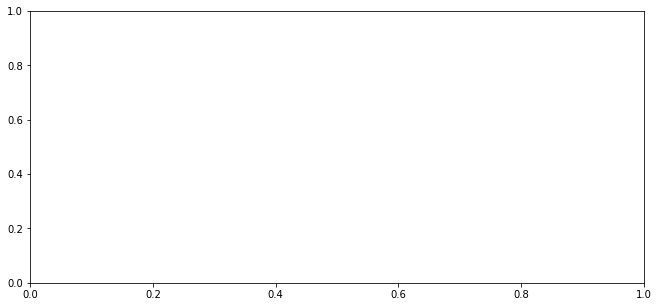

In [19]:
fig, ax = plt.subplots(figsize=(11,5))
ax.plot(infidelity_values,color='r')
ax.set_title(r"Variation of INfidelity each Iteration", fontsize=18)
ax.set_xlabel("Iterations", fontsize=18)
ax.set_ylabel(r" $INfidelity$", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14) 